# Flight Status Predictor - EDA

In [170]:
# Standard library imports
import os
import time
from time import sleep

# Third-party imports
import folium
from folium import Choropleth
from folium.plugins import HeatMap
import geopandas as gpd
import googlemaps
from IPython.display import display, HTML, IFrame
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from shapely.geometry import Point
import seaborn as sns

# Load environment variables from the .env file
from dotenv import load_dotenv
load_dotenv()

# Retrieve the API key from environment variables
api_key = os.getenv('google_api_key')

# Set pandas display options
pd.options.display.max_columns = 50

### Load Data

In [171]:
df = pd.read_csv('/Users/briantreftz/GitHubRepos/RawData/Flight_On_Time_Data.csv')
df.head()

,Carrier_Name,Year,Quarter,Month,Month_Day,Week_Day,Flight_Date,Airline_DOT_ID,Tail_Number,Flight_Number,Origin_Airport_ID,Origin_City_Market_ID,Origin_IATA_Code,Origin_City_State,Destination_Airport_ID,Destination_City_Market_ID,Destination_IATA_Code,Destination_City_State,Dep_Time_Block_Group,Scheduled_Departure_Time,Actual_Dep_Time,Dep_Time_Offset,Dep_Delay_Minutes,Dep_Delay_At_Least_15_Minutes,Scheduled_Arrival_Time,Arr_Time_Block_Group,Actual_Arr_Time,Arr_Time_Offset,Arr_Delay_Minutes,Arr_Delay_At_Least_15_Minutes,Flight_Cancelled,Flight_Diverted,Scheduled_Gate_to_Gate_Time,Actual_Gate_to_Gate_Time,Time_Airborne,Number_of_Flights,Distance_Miles,Distance_Group,Carrier_Delay,Weather_Delay,National_Aviation_System_Delay,Security_Delay,Late_Aircraft_Delay
0,United Air Lines Inc.,2023,2,Apr,26,Wednesday,2023-04-26,19977,N851UA,1788,11298,30194,DFW,"Dallas/Fort Worth, TX",11618,31703,EWR,"Newark, NJ",Evening,1926,1933,7,7,0,2359,Night,12,13,13,0,0,0,213,219,162,1,1372,6,NaN,NaN,NaN,NaN,NaN
1,United Air Lines Inc.,2023,2,Apr,26,Wednesday,2023-04-26,19977,N37530,1787,11292,30325,DEN,"Denver, CO",13871,33316,OMA,"Omaha, NE",Evening,2051,2130,39,39,1,2316,Night,3,47,47,1,0,0,85,93,65,1,472,2,39.0,0.0,8.0,0.0,0.0
2,United Air Lines Inc.,2023,2,Apr,26,Wednesday,2023-04-26,19977,N78509,1786,12892,32575,LAX,"Los Angeles, CA",11042,30647,CLE,"Cleveland, OH",Night,2328,2319,-9,0,0,701,Early Morning,650,-11,0,0,0,0,273,271,249,1,2052,9,NaN,NaN,NaN,NaN,NaN
3,United Air Lines Inc.,2023,2,Apr,26,Wednesday,2023-04-26,19977,N47280,1785,10721,30721,BOS,"Boston, MA",12264,30852,IAD,"Washington, DC",Early Morning,600,557,-3,0,0,735,Early Morning,724,-11,0,0,0,0,95,87,69,1,413,2,NaN,NaN,NaN,NaN,NaN
4,United Air Lines Inc.,2023,2,Apr,26,Wednesday,2023-04-26,19977,N826UA,1784,14747,30559,SEA,"Seattle, WA",11292,30325,DEN,"Denver, CO",Morning,1116,1113,-3,0,0,1459,Early Afternoon,1453,-6,0,0,0,0,163,160,129,1,1024,5,NaN,NaN,NaN,NaN,NaN


### Organize DataFrame

To prepare the dataframe for analysis I will do the following steps:
1. Drop redundant/extraneous columns
2. Rename columns
3. Group numerical columns
4. Move target variable column to the end of the dataframe
5. Sort dataframe by month column chronologically

In [172]:
# Getting list of column names
df.columns

Index(['Carrier_Name', 'Year', 'Quarter', 'Month', 'Month_Day', 'Week_Day',
       'Flight_Date', 'Airline_DOT_ID', 'Tail_Number', 'Flight_Number',
       'Origin_Airport_ID', 'Origin_City_Market_ID', 'Origin_IATA_Code',
       'Origin_City_State', 'Destination_Airport_ID',
       'Destination_City_Market_ID', 'Destination_IATA_Code',
       'Destination_City_State', 'Dep_Time_Block_Group',
       'Scheduled_Departure_Time', 'Actual_Dep_Time', 'Dep_Time_Offset',
       'Dep_Delay_Minutes', 'Dep_Delay_At_Least_15_Minutes',
       'Scheduled_Arrival_Time', 'Arr_Time_Block_Group', 'Actual_Arr_Time',
       'Arr_Time_Offset', 'Arr_Delay_Minutes', 'Arr_Delay_At_Least_15_Minutes',
       'Flight_Cancelled', 'Flight_Diverted', 'Scheduled_Gate_to_Gate_Time',
       'Actual_Gate_to_Gate_Time', 'Time_Airborne', 'Number_of_Flights',
       'Distance_Miles', 'Distance_Group', 'Carrier_Delay', 'Weather_Delay',
       'National_Aviation_System_Delay', 'Security_Delay',
       'Late_Aircraft_Delay'],

In [173]:
# Dropping columns
df = df[['Carrier_Name',
        #'Year', 'Quarter',
        'Month',
        #'Month_Day',
        'Week_Day',
        'Flight_Date', 
        #'Airline_DOT_ID',
        'Tail_Number',
        #'Flight_Number',
        #'Origin_Airport_ID', 'Origin_City_Market_ID',
        'Origin_IATA_Code',
        'Origin_City_State', 
        #'Destination_Airport_ID','Destination_City_Market_ID',
        'Destination_IATA_Code',
        'Destination_City_State',
        'Dep_Time_Block_Group',
        'Scheduled_Departure_Time',
        #'Actual_Dep_Time', 'Dep_Time_Offset',
        #'Dep_Delay_Minutes', 'Dep_Delay_At_Least_15_Minutes',
        'Scheduled_Arrival_Time',
        'Arr_Time_Block_Group', #'Actual_Arr_Time',
        #'Arr_Time_Offset', 
        'Arr_Delay_Minutes','Arr_Delay_At_Least_15_Minutes',
        #'Flight_Cancelled', 'Flight_Diverted', 'Scheduled_Gate_to_Gate_Time',
        #'Actual_Gate_to_Gate_Time', 'Time_Airborne', 'Number_of_Flights',
        'Distance_Miles',
        'Distance_Group',
        #'Carrier_Delay', 'Weather_Delay',
        #'National_Aviation_System_Delay', 'Security_Delay',
        #'Late_Aircraft_Delay'
]].copy()

# Renaming columns
df.rename(columns={'Arr_Delay_At_Least_15_Minutes':'Delayed',
                'Origin_IATA_Code':'Origin',
                'Destination_IATA_Code':'Destination'
                }, inplace = True)

# Columns to move
cols_to_move = [
                'Distance_Miles',
                'Scheduled_Departure_Time',
                'Scheduled_Arrival_Time'
                ]

last_col = 'Delayed'

# Extracting the columns to move
columns_to_move = df[cols_to_move]

# Dropping these columns from the DataFrame
df.drop(columns=cols_to_move, inplace=True)

# Extracting the last column
last_column = df.pop(last_col)

# Reinserting the numerical columns
df = pd.concat([df, columns_to_move], axis=1)

# Reinserting the last column
df[last_col] = last_column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6777978 entries, 0 to 6777977
Data columns (total 17 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Carrier_Name              object
 1   Month                     object
 2   Week_Day                  object
 3   Flight_Date               object
 4   Tail_Number               object
 5   Origin                    object
 6   Origin_City_State         object
 7   Destination               object
 8   Destination_City_State    object
 9   Dep_Time_Block_Group      object
 10  Arr_Time_Block_Group      object
 11  Arr_Delay_Minutes         int64 
 12  Distance_Group            int64 
 13  Distance_Miles            int64 
 14  Scheduled_Departure_Time  int64 
 15  Scheduled_Arrival_Time    int64 
 16  Delayed                   int64 
dtypes: int64(6), object(11)
memory usage: 879.1+ MB


In [174]:
# List of months in chronological order
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert the 'Month' column to a categorical type with the specified order
df['Month'] = pd.Categorical(df['Month'], categories=month_list, ordered=True)

# Sort the DataFrame by the 'Month' column
df = df.sort_values('Month')

# Display the sorted DataFrame
df.head()

,Carrier_Name,Month,Week_Day,Flight_Date,Tail_Number,Origin,Origin_City_State,Destination,Destination_City_State,Dep_Time_Block_Group,Arr_Time_Block_Group,Arr_Delay_Minutes,Distance_Group,Distance_Miles,Scheduled_Departure_Time,Scheduled_Arrival_Time,Delayed
5672245,United Air Lines Inc.,Jan,Friday,2024-01-05,N72405,IAH,"Houston, TX",IND,"Indianapolis, IN",Early Afternoon,Afternoon,17,4,844,1225,1539,1
5502181,Southwest Airlines Co.,Jan,Tuesday,2024-01-30,N944WN,MDW,"Chicago, IL",CVG,"Cincinnati, OH",Morning,Morning,0,1,249,845,1055,0
5502180,Southwest Airlines Co.,Jan,Tuesday,2024-01-30,N253WN,MDW,"Chicago, IL",CVG,"Cincinnati, OH",Early Afternoon,Afternoon,0,1,249,1340,1550,0
5502179,Southwest Airlines Co.,Jan,Tuesday,2024-01-30,N8514F,MDW,"Chicago, IL",COS,"Colorado Springs, CO",Early Afternoon,Afternoon,0,4,917,1330,1510,0
5502178,Southwest Airlines Co.,Jan,Tuesday,2024-01-30,N217JC,MDW,"Chicago, IL",CMH,"Columbus, OH",Morning,Morning,0,2,283,840,1050,0


### Understanding the Dataset
To start, let's get familiar with the dataset by looking at the key features and the target variable.

- **Potential Key Features:** 
    - Carrier_Name 
    - Month 
    - Week_Day
    - Tail_Number 
    - Origin 
    - Destination 
    - Dep_Time_Block_Group 
    - Arr_Time_Block_Group
    - Distance_Group            
    - Distance_Miles            
    - Scheduled_Departure_Time  
    - Scheduled_Arrival_Time   
    
    ** **Flight_Date** will be dropped after checking for duplicate rows.   
- **Target Variable:** 
    - Delayed (1 for yes, 0 for no)


### Data Dictionary

| Variable | Class | Description |
| -------  | ----- | ----------- |
| Carrier_Name | String | Name of Airline/Carrier. | 
| Month | String | Month (Jan, Feb, Mar, etc.) |
| Week_Day | String | Day of the week. |
| Tail_Number | String | Unique identifier for aircraft |
| Origin | String | Origin IATA Code. The International Air Transport Association (IATA) code is three-letter geo-code used to designate airports and metropolitan areas. |
| Destination | String | Destination IATA Code. See above.  |
| Dep_Time_Block_Group | String | Departure Time Block Group: This feature "bins" departure flight times into one of six colloquial segments — Early Morning (12-8 AM), Morning (8 AM - 12 PM), Early Afternoon (12-3 PM), Afternoon (3-6 PM), Evening (6-9 PM), and Night (9 PM - 12 AM). |
| Arr_Time_Block_Group | String |  Arrival Time Block Group. See above. |
| Arr_Delay_Minutes | Int | Difference in minutes between scheduled and actual arrival time. Early arrivals set to 0. |
| Distance_Group | Int | Distance intervals in 250-mile increments. |            
| Distance_Miles | Int | Distance between airports in miles. |           
| Scheduled_Departure_Time | Int | Scheduled Departure Time (local time: hhmm) |  
| Scheduled_Arrival_Time | Int | Scheduled Arrival Time (local time: hhmm) |
| Delayed | Int | Arrival Delay Indicator, 15 Minutes or More (1=Yes) |   



### Data Quality Check
Next, we will check for missing values and duplicates in the dataset.

In [175]:
# Check for missing values
missing = df.isnull().sum()
print('The number of missing values for each feature and the target is:')
print(missing,'\n')

# Check for duplicates
subset = df.columns.values
duplicates = df.duplicated(subset=subset).sum()
print(f'The number of duplicate rows in the dataset is: {duplicates}')

# Drop Flight_Date column
df.drop(['Flight_Date'], axis=1, inplace=True)

The number of missing values for each feature and the target is:
Carrier_Name                0
Month                       0
Week_Day                    0
Flight_Date                 0
Tail_Number                 0
Origin                      0
Origin_City_State           0
Destination                 0
Destination_City_State      0
Dep_Time_Block_Group        0
Arr_Time_Block_Group        0
Arr_Delay_Minutes           0
Distance_Group              0
Distance_Miles              0
Scheduled_Departure_Time    0
Scheduled_Arrival_Time      0
Delayed                     0
dtype: int64 

The number of duplicate rows in the dataset is: 0


### Summary Statistics

#### Numerical Data

Arr_Delay_Minutes is further examined in the Delayed Flights Analysis below.

In [179]:
# Disable scientific notation
pd.set_option('display.float_format', '{:.1f}'.format)

# Describe Numerical Value
df[['Distance_Miles', 'Scheduled_Departure_Time', 'Scheduled_Arrival_Time', 'Arr_Delay_Minutes']].describe().astype(int)

,Distance_Miles,Scheduled_Departure_Time,Scheduled_Arrival_Time,Arr_Delay_Minutes
count,6777978,6777978,6777978,6777978
mean,835,1329,1487,15
std,597,495,524,54
min,21,1,1,0
25%,399,906,1100,0
50%,680,1320,1515,0
75%,1069,1740,1925,9
max,5095,2400,2400,3795


#### Categorical Data

In [180]:
# Ensure Distance_Group is treated as a categorical variable
df['Distance_Group'] = df['Distance_Group'].astype('category')

# Describe Categorical Values
df[['Carrier_Name',
   'Month',
   'Week_Day',
   'Tail_Number',
   'Origin','Destination',
   'Dep_Time_Block_Group',
   'Arr_Time_Block_Group',
   'Distance_Group'
]].describe()

,Carrier_Name,Month,Week_Day,Tail_Number,Origin,Destination,Dep_Time_Block_Group,Arr_Time_Block_Group,Distance_Group
count,6777978,6777978,6777978,6777978,6777978,6777978,6777978,6777978,6777978
unique,15,12,7,5969,348,348,6,6,11
top,Southwest Airlines Co.,Oct,Friday,N488HA,ATL,ATL,Morning,Morning,2
freq,1436531,596003,1006397,3387,333791,333809,1675136,1541215,1537278


For the scope of this initial model, we will drop Tail_Number due to its high cardinality. In future versions of this model, we may consider including it.

In [181]:
df.drop('Tail_Number', axis=1, inplace = True)

### Feature Analysis
Let's examine the distributions of numerical and categorical features.


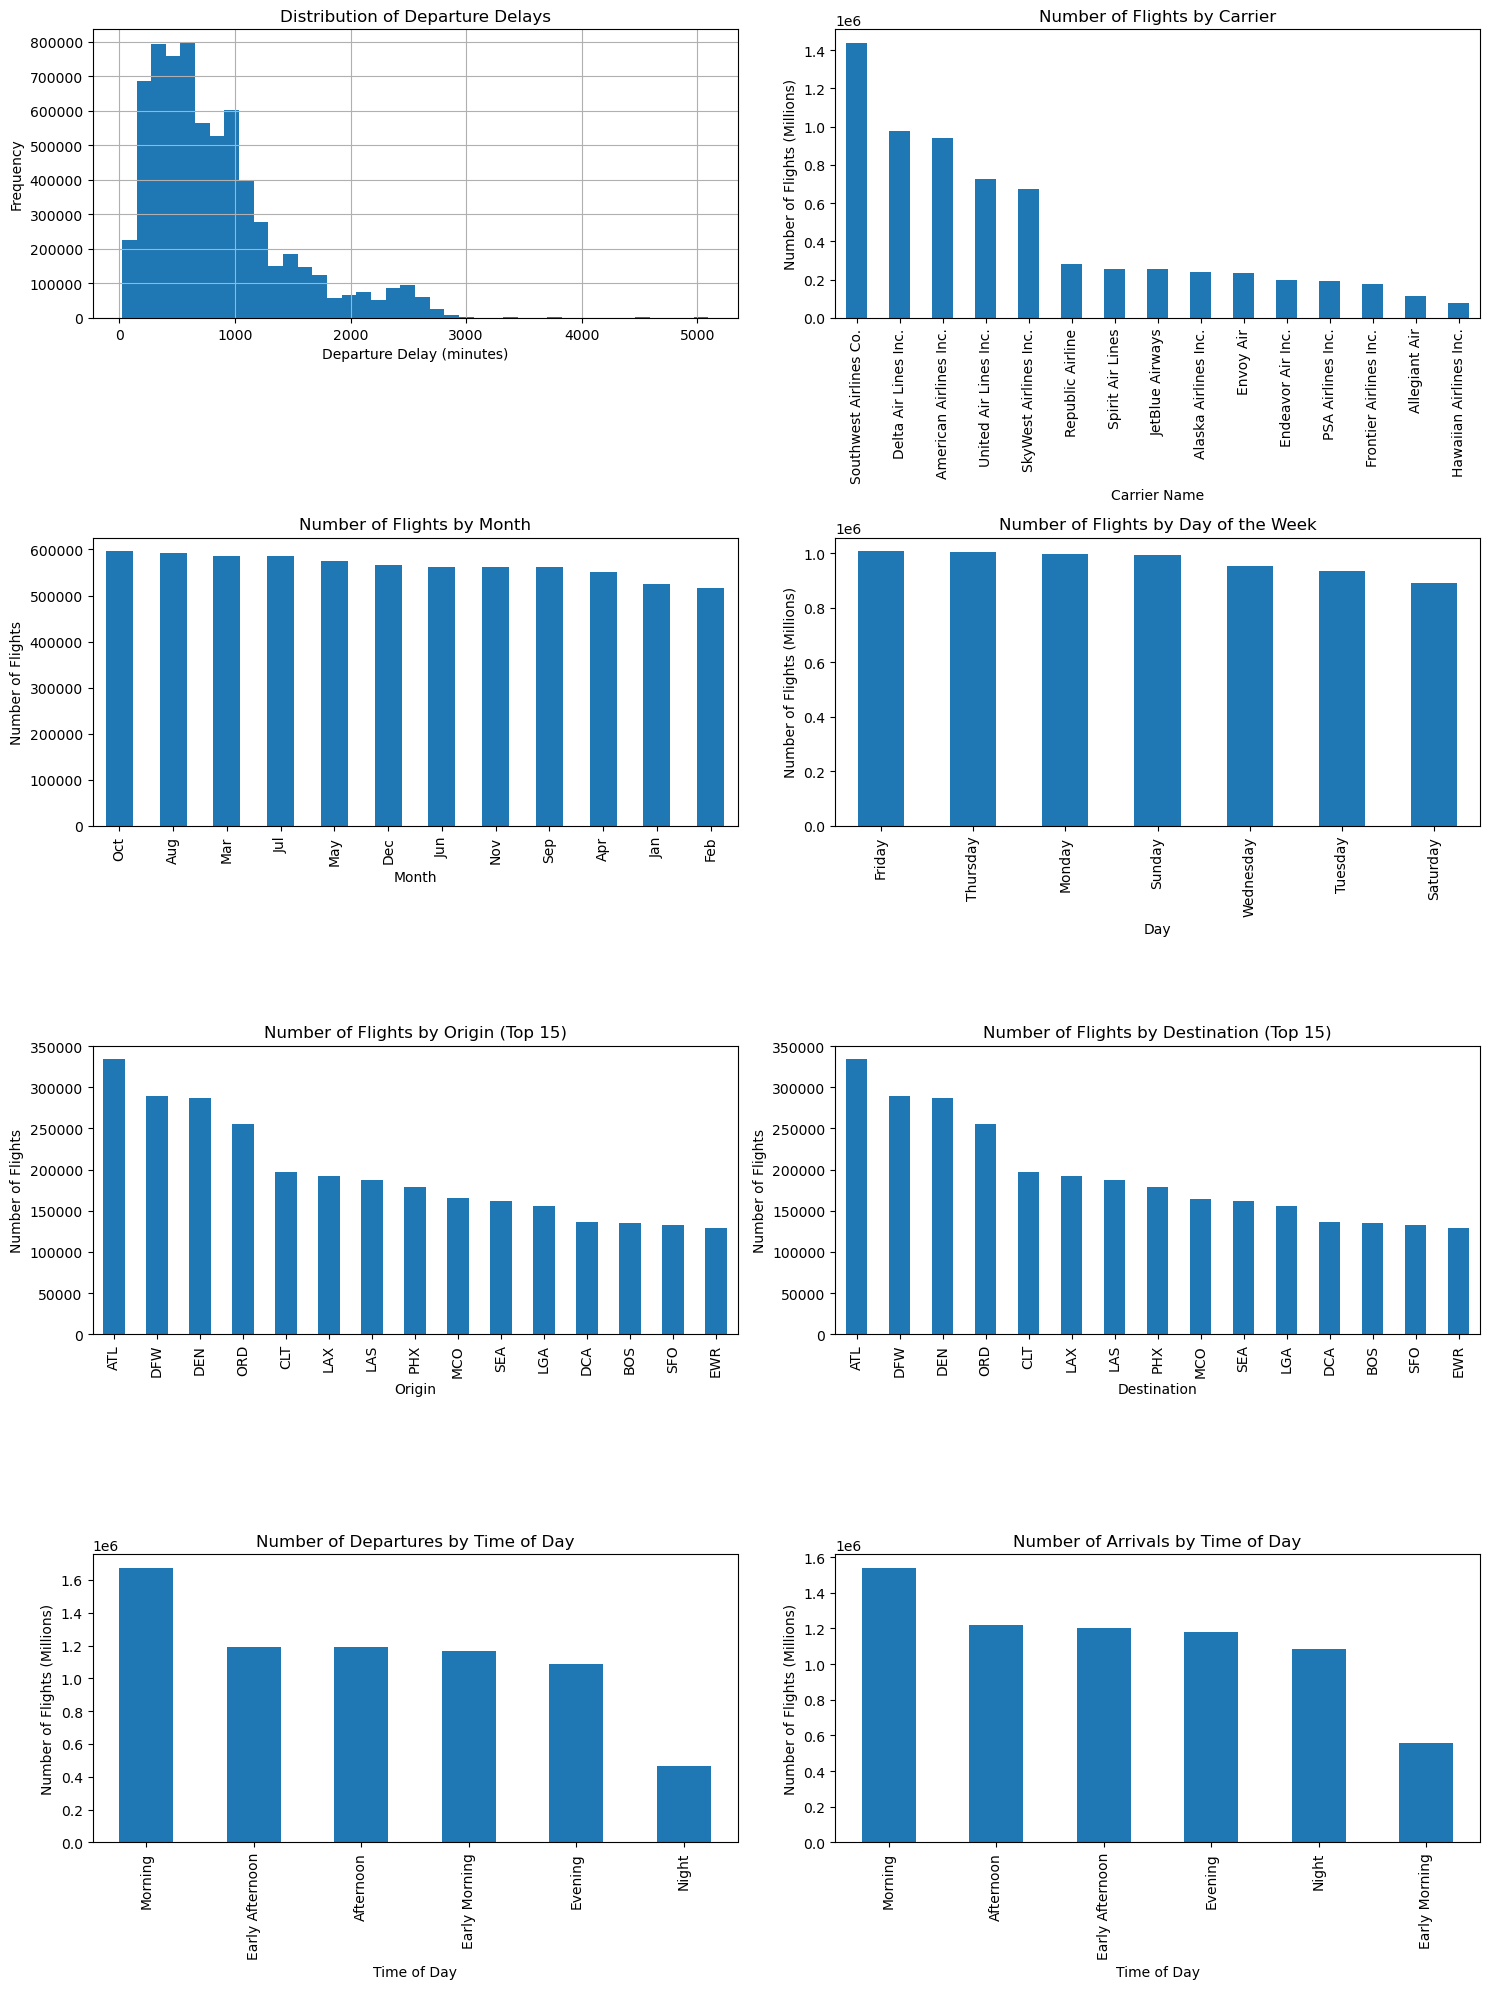

In [182]:
# Create a 4x2 subplot
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Histogram for a numerical feature
df['Distance_Miles'].hist(bins=40, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Departure Delays')
axes[0, 0].set_xlabel('Departure Delay (minutes)')
axes[0, 0].set_ylabel('Frequency')

# Bar chart for a categorical feature
df['Carrier_Name'].value_counts().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Number of Flights by Carrier')
axes[0, 1].set_xlabel('Carrier Name')
axes[0, 1].set_ylabel('Number of Flights (Millions)')

df['Month'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 0].set_title('Number of Flights by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Flights')

df['Week_Day'].value_counts().plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Number of Flights by Day of the Week')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Number of Flights (Millions)')

df['Origin'].value_counts().nlargest(15).sort_values(ascending=False).plot(kind='bar', ax=axes[2, 0])
axes[2, 0].set_title('Number of Flights by Origin (Top 15)')
axes[2, 0].set_xlabel('Origin')
axes[2, 0].set_ylabel('Number of Flights')

df['Destination'].value_counts().nlargest(15).sort_values(ascending=False).plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_title('Number of Flights by Destination (Top 15)')
axes[2, 1].set_xlabel('Destination')
axes[2, 1].set_ylabel('Number of Flights')

df['Dep_Time_Block_Group'].value_counts().plot(kind='bar', ax=axes[3, 0])
axes[3, 0].set_title('Number of Departures by Time of Day')
axes[3, 0].set_xlabel('Time of Day')
axes[3, 0].set_ylabel('Number of Flights (Millions)')

df['Arr_Time_Block_Group'].value_counts().plot(kind='bar', ax=axes[3, 1])
axes[3, 1].set_title('Number of Arrivals by Time of Day')
axes[3, 1].set_xlabel('Time of Day')
axes[3, 1].set_ylabel('Number of Flights (Millions)')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()


### Relationships Between Features
We will explore the correlations between numerical features and the relationship between categorical features and the target variable.


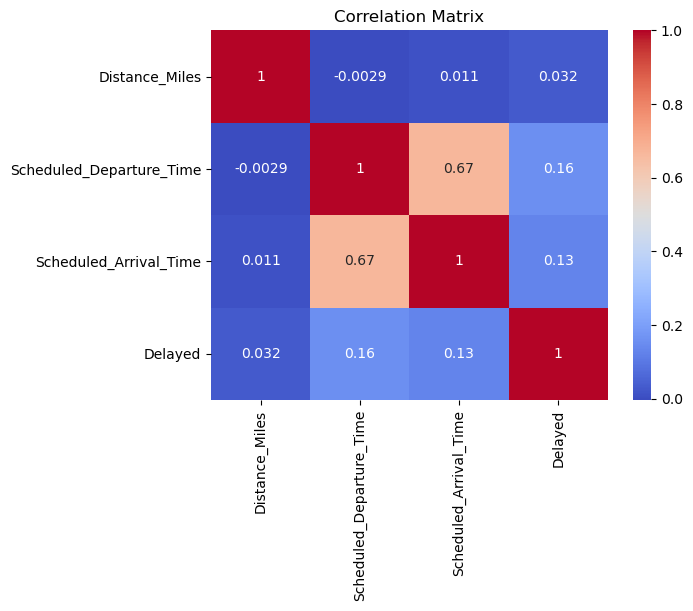

/var/folders/7p/1g8hxnj16nn91rxhv3tvss700000gn/T/ipykernel_85358/1835340318.py:49: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5)


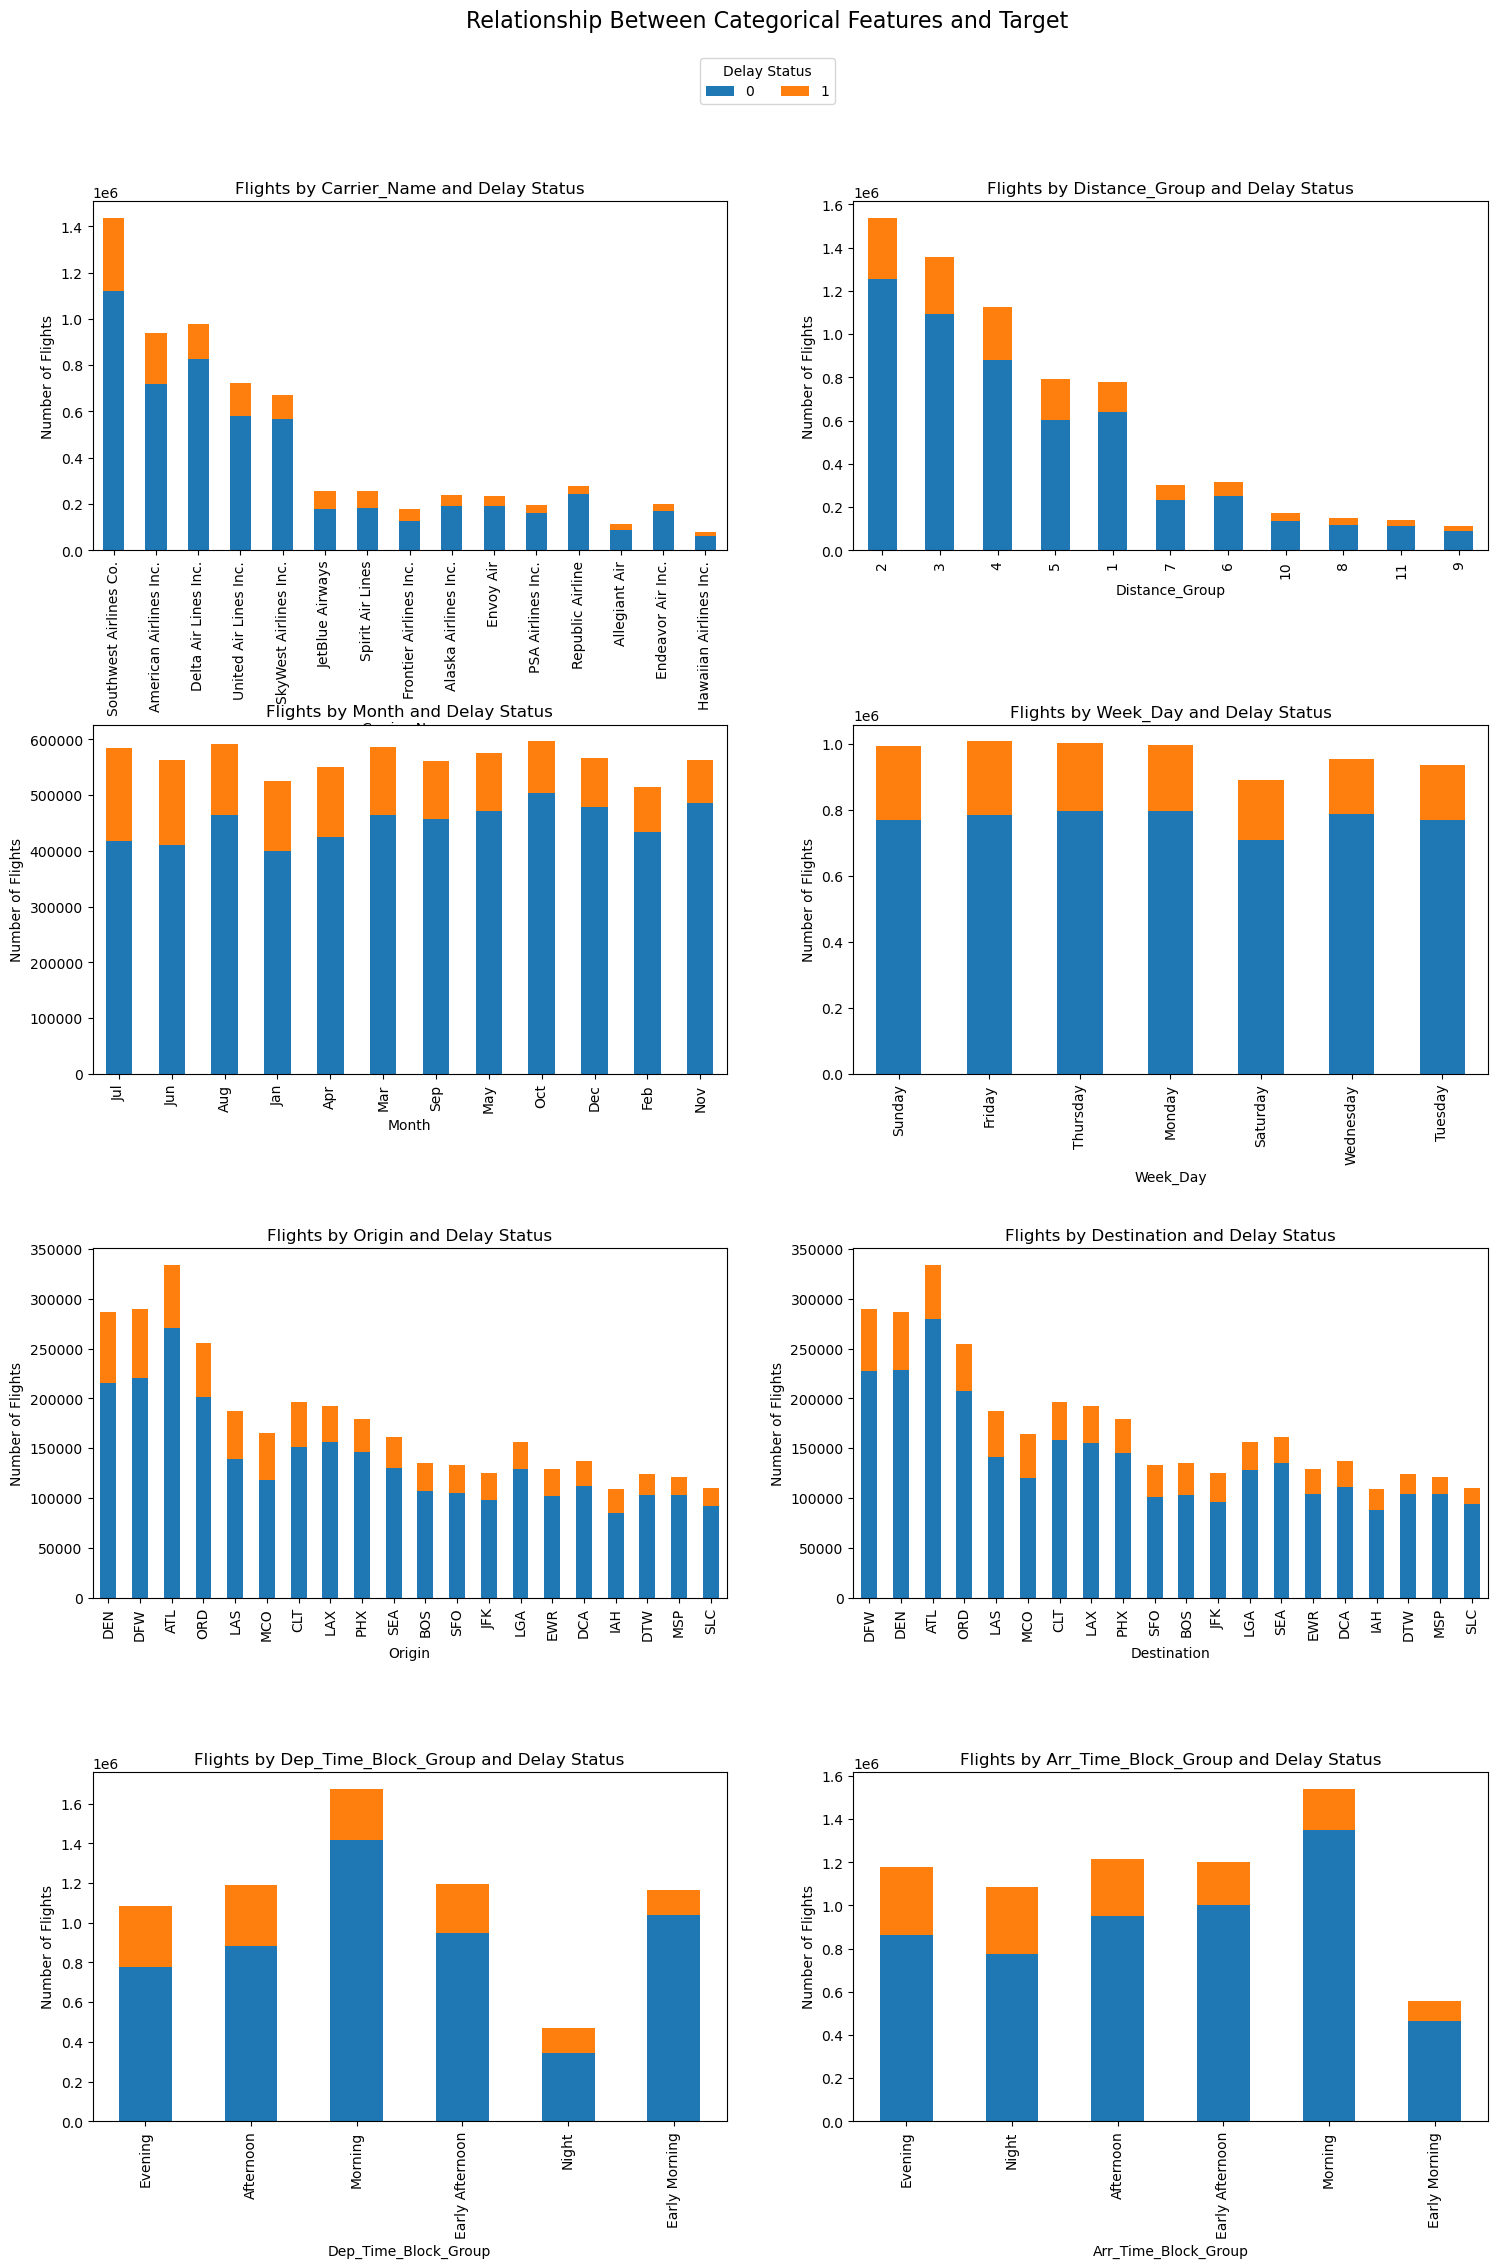

In [106]:
# Filter only numerical columns
numerical_features = df.select_dtypes(include=['number'])
corr_matrix = numerical_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Relationship between categorical features and the target variable
# Define the categorical features
categorical_features = ['Carrier_Name', 
                        'Distance_Group', 
                        'Month', 
                        'Week_Day', 
                        'Origin', 
                        'Destination', 
                        'Dep_Time_Block_Group', 
                        'Arr_Time_Block_Group']

# Create a 4x2 subplot
fig, axes = plt.subplots(4, 2, figsize=(18, 24), constrained_layout=True)
fig.suptitle('Relationship Between Categorical Features and Target', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the categorical features and create a bar plot for each
for i, feature in enumerate(categorical_features):
    if feature in ['Origin', 'Destination']:
        # Get the top 20 values for Origin and Destination
        top_20 = df[feature].value_counts().nlargest(20).index
        crosstab = pd.crosstab(df[feature][df[feature].isin(top_20)], df['Delayed'])
    else:
        crosstab = pd.crosstab(df[feature], df['Delayed'])
    
    # Sort the crosstab by the number of delayed flights in descending order
    crosstab = crosstab.sort_values(by=1, ascending=False)
    
    # Plot the crosstab
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f'Flights by {feature} and Delay Status')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Number of Flights')

# Add the legend below the title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, .95), ncol=2, title='Delay Status')

# Adjust the layout to ensure the legend does not overlap with the title or subplots
plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.5)

plt.show()


## Delayed Flights Analysis

### Total Number and Percentage of Delayed Flights

> Out of 6.78 Million Total Flights:   
> 1.37 Million (20.2%) were delayed more than 15 minutes.


Total Number of Flights = 6,777,978
Number of Delayed Flights = 1,371,451
Percentage of Delayed Flights = 20.2 %


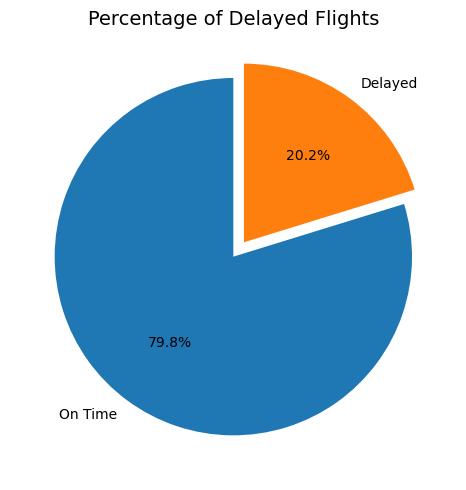

In [107]:
# Extract total number of flights
num_flights = df['Delayed'].count()

# Extract total number of on time and delayed flights
on_time, delayed = df['Delayed'].value_counts()

# Display total number of flights, delayed flights, and percentage delayed flights
print(f'Total Number of Flights = {num_flights:,}')
print(f'Number of Delayed Flights = {delayed:,}')
print(f'Percentage of Delayed Flights = {(delayed/num_flights)*100:.3} %')

# Visualizing Delayed Flight Percentage

# Data and Labels
data = [on_time, delayed]
keys = ['On Time', 'Delayed']

# Pie Chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    data,
    labels=keys,
    autopct='%1.1f%%',
    startangle=90,
    explode=[0, 0.1]
)


# Adjusting Figure Size
fig.set_size_inches(5, 5)

# Title and Layout Adjustments
plt.title('Percentage of Delayed Flights', fontsize=14)
plt.tight_layout()

# Display the plot
plt.show()

### Examine Time Elapsed Passed Scheduled Arrival Time for Flights  >=  15 min. Late

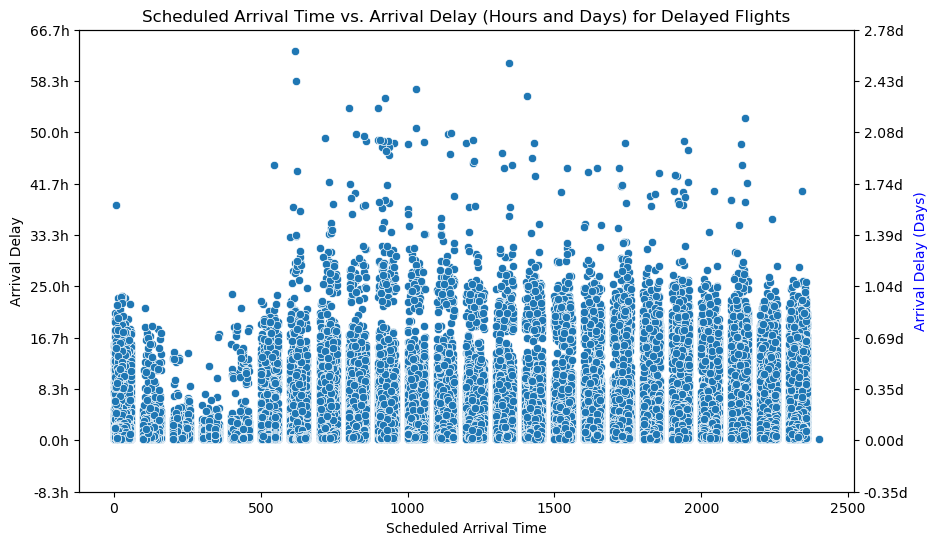

Descriptive Statistics for Arrival Delay Minutes (Delayed Flights):
count   1371451.0
mean         70.0
std         103.8
min          15.0
25%          24.0
50%          40.0
75%          77.0
max        3795.0
Name: Arr_Delay_Minutes, dtype: float64


In [205]:
# Dropping unneeded columns
drop_col = ['Carrier_Name', 'Month', 'Week_Day', 'Origin', 'Origin_City_State',
        'Destination', 'Destination_City_State', 'Dep_Time_Block_Group',
        'Arr_Time_Block_Group', 'Distance_Group',
        'Distance_Miles', 'Scheduled_Departure_Time',]

# Filter the DataFrame where Delayed column equals 1
df_delayed = df[df['Delayed'] == 1].drop(columns = drop_col).copy()

# Convert arrival delay from minutes to hours and days
df_delayed['Arr_Delay_Hours'] = df_delayed['Arr_Delay_Minutes'] / 60
df_delayed['Arr_Delay_Days'] = df_delayed['Arr_Delay_Minutes'] / 1440  # 1440 minutes in a day

# Plot the scatter plot
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x=df_delayed['Scheduled_Arrival_Time'], y=df_delayed['Arr_Delay_Minutes'])

# Set title and labels
plt.title('Scheduled Arrival Time vs. Arrival Delay (Hours and Days) for Delayed Flights')
plt.xlabel('Scheduled Arrival Time')
plt.ylabel('Arrival Delay')

# Customize y-axis labels
def format_ticks(value, tick_type='minutes'):
    if tick_type == 'hours':
        return f'{value / 60:.1f}h'
    elif tick_type == 'days':
        return f'{value / 1440:.2f}d'
    return f'{value}m'

# Get current y-ticks
current_ticks = scatter_plot.get_yticks()

# Set y-ticks for hours
y_ticks_hours = [format_ticks(tick, 'hours') for tick in current_ticks]
scatter_plot.set_yticks(current_ticks)
scatter_plot.set_yticklabels(y_ticks_hours)

# Add secondary y-axis for days
ax2 = scatter_plot.twinx()
ax2.set_ylim(scatter_plot.get_ylim())
ax2.set_yticks(current_ticks)
ax2.set_yticklabels([format_ticks(tick, 'days') for tick in current_ticks])
ax2.set_ylabel('Arrival Delay (Days)', color='blue')

# Show plot
plt.show()

# Print the descriptive statistics
print("Descriptive Statistics for Arrival Delay Minutes (Delayed Flights):")
print(df_delayed['Arr_Delay_Minutes'].describe())


### Percentage of Delayed Flights by Feature Value

> From the flights that were delayed:  
> More than 20% were from Southwest Airlines  
> ~12% occurred in July  
> ~16% occurred on a Sunday  
> ~5% started in Denver International Airport - City & County of Denver Dept of Aviation  
> Just shy of 5% ended in Dallas Fort Worth International Airport (DFW)  
> Over 40% departed from their origin in the afternoon (3-6 PM) or evening (6-9 PM)  

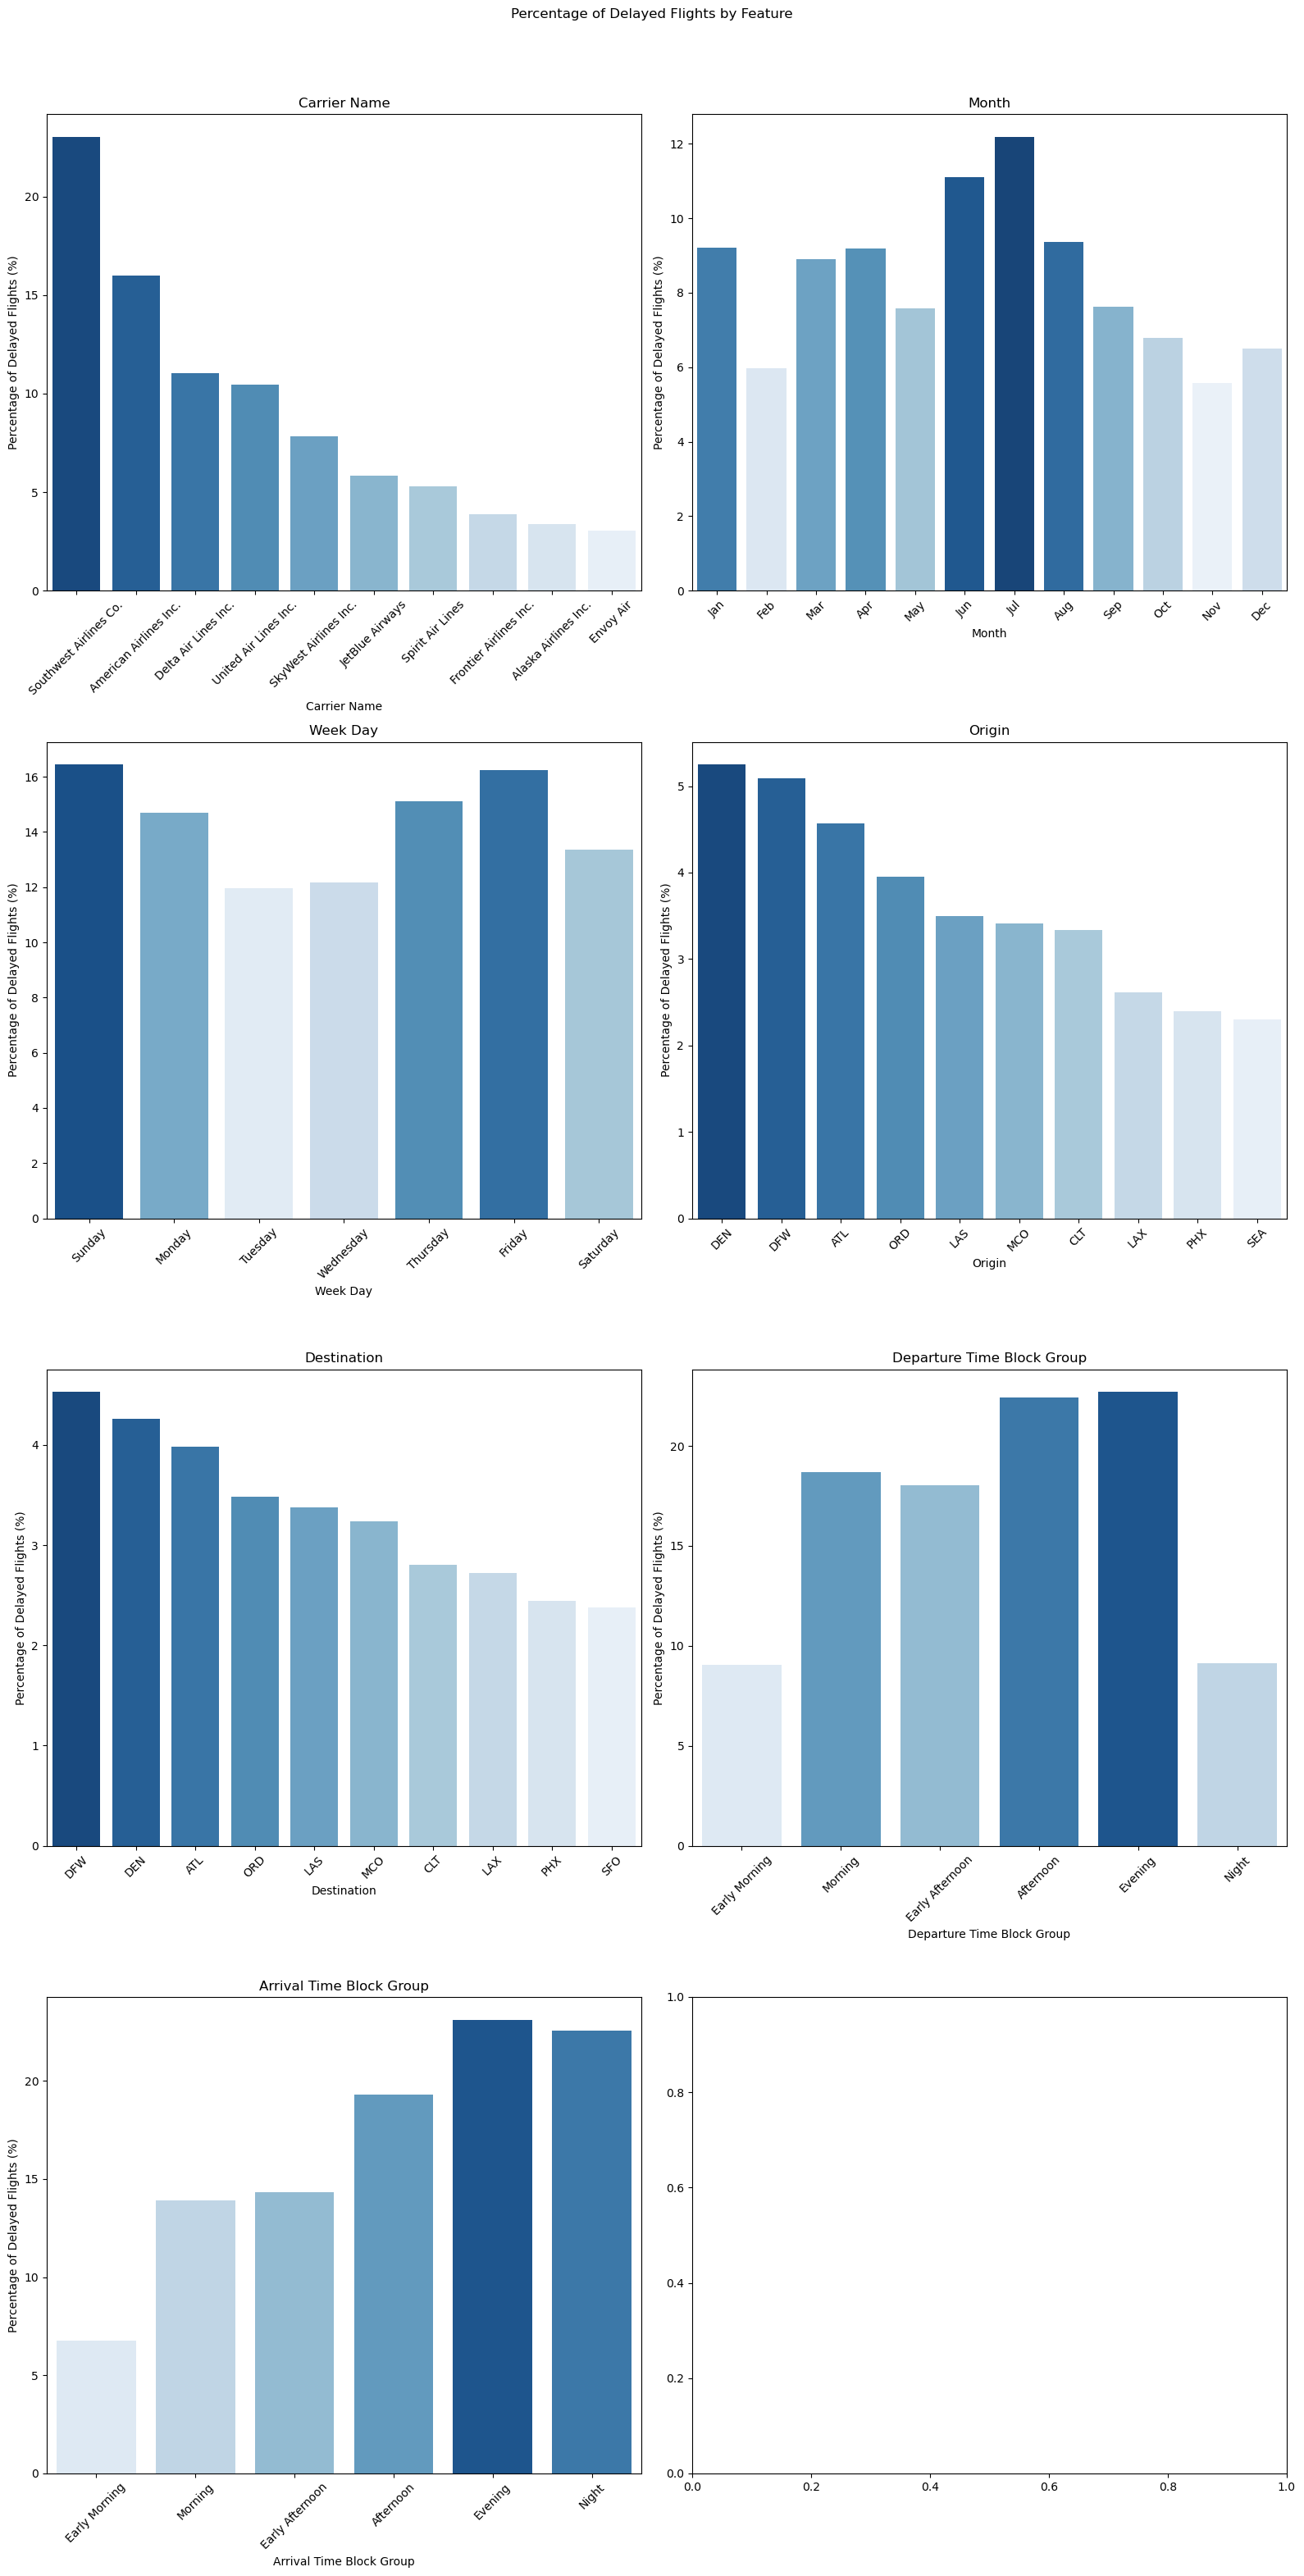

In [108]:
# Define categorical variables
categorical_features = [
    ('Carrier_Name', 'Carrier Name'),
    ('Month', 'Month'),
    ('Week_Day', 'Week Day'),
    ('Origin', 'Origin'),
    ('Destination', 'Destination'),
    ('Dep_Time_Block_Group', 'Departure Time Block Group'),
    ('Arr_Time_Block_Group', 'Arrival Time Block Group')
]

# Initialize subplot figure with two columns of four
fig, axs = plt.subplots(4, 2, figsize=(16, 32))
axs = axs.flatten()

# Create bar charts for each categorical variable
for i, (var, title) in enumerate(categorical_features):
    if var in ['Origin', 'Destination', 'Carrier_Name']:
        # Limit top 10 for Origin, Destination, and Carrier
        top_10 = df[df['Delayed'] == 1][var].value_counts().head(10).sort_values(ascending=False)
        labels = top_10.index
        values = (top_10.values / delayed) * 100
    elif var == 'Month':
        # Sort month in order from January to December
        month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        month_counts = df[df['Delayed'] == 1]['Month'].value_counts(normalize=True).reindex(month_order)
        labels = month_counts.index
        values = month_counts.values * 100
    elif var == 'Week_Day':
        # Sort week day from Sunday to Saturday
        weekday_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
        weekday_counts = df[df['Delayed'] == 1]['Week_Day'].value_counts(normalize=True).reindex(weekday_order)
        labels = weekday_counts.index
        values = weekday_counts.values * 100
    elif var == 'Dep_Time_Block_Group':
        # Sort time block group from Early Morning to Night
        dep_block_order = ['Early Morning', 'Morning', 'Early Afternoon', 'Afternoon', 'Evening', 'Night']
        dep_block_counts = df[df['Delayed'] == 1]['Dep_Time_Block_Group'].value_counts(normalize=True).reindex(dep_block_order)
        labels = dep_block_counts.index
        values = dep_block_counts.values * 100
    else:
        # Sort time block group from Early Morning to Night
        arr_block_order = ['Early Morning', 'Morning', 'Early Afternoon', 'Afternoon', 'Evening', 'Night']
        arr_block_counts = df[df['Delayed'] == 1]['Arr_Time_Block_Group'].value_counts(normalize=True).reindex(arr_block_order)
        labels = arr_block_counts.index
        values = arr_block_counts.values * 100

    # Create a color palette from light to dark
    palette = sns.color_palette("Blues", len(values))
    rank = np.argsort(values)
    rank_order = np.empty_like(rank)
    rank_order[rank] = np.arange(len(values))
    colors = [palette[r] for r in rank_order]

    # Create bar chart with the color palette
    sns.barplot(x=labels, y=values, ax=axs[i], palette=colors)

    # Set title and labels
    axs[i].set_title(title)
    axs[i].set_xlabel(title)
    axs[i].set_ylabel('Percentage of Delayed Flights (%)')
    axs[i].tick_params(axis='x', rotation=45)

# Update layout
plt.suptitle('Percentage of Delayed Flights by Feature')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plot
plt.show()


### Temporal Analysis
When we analyze how delay rates vary over time we can clearly see that the highest rate of delays occur in July and the least in November.

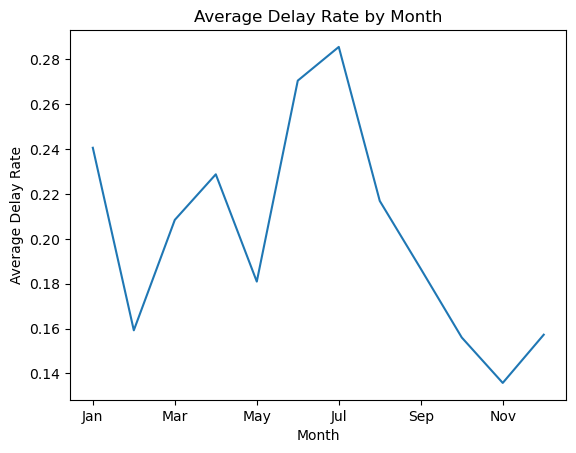

In [109]:
# Time series analysis by month
df.groupby('Month', observed=False)['Delayed'].mean().plot(kind='line')
plt.title('Average Delay Rate by Month')
plt.xlabel('Month')
plt.ylabel('Average Delay Rate')
plt.show()


### Geographical Analysis
We will explore the patterns in delays based on the origin and destination cities. Fwom the bubble charts below it appears flights to and from Florida experience a lot of delays.


In [63]:

# Initialize Google Maps client
gmaps = googlemaps.Client(key=api_key)

# Function to geocode a city-state
def geocode_city_state(city_state):
    try:
        # Geocoding the city-state
        result = gmaps.geocode(city_state)
        if result:
            # Extracting the latitude and longitude
            location = result[0]['geometry']['location']
            return location['lat'], location['lng']
        else:
            return None, None
    except Exception as e:
        print(f"Error geocoding {city_state}: {e}")
        return None, None

# Extract unique values from 'Destination_City_State'
unique_city_states = df['Destination_City_State'].unique()

# Create a dictionary to store geocoding results
geocode_cache = {}

# Geocode each unique city-state and store the results in the dictionary
for city_state in unique_city_states:
    lat, lng = geocode_city_state(city_state)
    geocode_cache[city_state] = (lat, lng)
    time.sleep(0.1)  # Sleep to respect rate limits

# Create separate dictionaries for latitude and longitude
latitude_dict = {k: v[0] for k, v in geocode_cache.items()}
longitude_dict = {k: v[1] for k, v in geocode_cache.items()}

In [167]:
# Function to add Latitude and Longitude to DataFrame based on city-state
def add_lat_long(df, column_name):
    df['Latitude'] = df[column_name].map(latitude_dict)
    df['Longitude'] = df[column_name].map(longitude_dict)
    return df

# Ensure the DataFrame has the necessary columns
required_columns = ['Origin_City_State', 'Destination_City_State', 'Delayed']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"DataFrame must contain the following columns: {required_columns}")

try:
    # Create separate DataFrames for Origin and Destination
    origin_df = df[['Origin_City_State', 'Delayed']].copy()
    origin_df = add_lat_long(origin_df, 'Origin_City_State')

    destination_df = df[['Destination_City_State', 'Delayed']].copy()
    destination_df = add_lat_long(destination_df, 'Destination_City_State')

    # Drop rows with missing latitude or longitude
    origin_df = origin_df.dropna(subset=['Latitude', 'Longitude'])
    destination_df = destination_df.dropna(subset=['Latitude', 'Longitude'])

    # Aggregate data
    def aggregate_data(df, location_col):
        aggregated = df.groupby(location_col).agg(
            Total_Flights=pd.NamedAgg(column='Delayed', aggfunc='count'),
            Total_Delayed=pd.NamedAgg(column='Delayed', aggfunc='sum'),
            Latitude=pd.NamedAgg(column='Latitude', aggfunc='first'),
            Longitude=pd.NamedAgg(column='Longitude', aggfunc='first')
        ).reset_index()
        aggregated['Percentage_Delayed'] = (aggregated['Total_Delayed'] / aggregated['Total_Flights']) * 100
        return aggregated

    origin_agg = aggregate_data(origin_df, 'Origin_City_State')
    destination_agg = aggregate_data(destination_df, 'Destination_City_State')

    # Function to get color based on percentage of delayed flights
    def get_color(percentage):
        norm = mcolors.Normalize(vmin=0, vmax=50)  # Adjusted to max 50%
        cmap = plt.get_cmap('YlOrRd')
        return mcolors.to_hex(cmap(norm(percentage)))

    # Function to create a bubble chart
    def create_bubble_chart(data, file_name, title, location_col):
        # Initialize the map centered around the average coordinates
        map_center = [data['Latitude'].mean(), data['Longitude'].mean()]
        m = folium.Map(location=map_center, zoom_start=4, tiles='OpenStreetMap')

        # Calculate radius scale
        max_flights = data['Total_Flights'].max()
        min_flights = data['Total_Flights'].min()

        # Add bubble markers to the map
        for _, row in data.iterrows():
            fill_color = get_color(row['Percentage_Delayed'])
            
            # Square root transformation
            radius = 1 + (np.sqrt(row['Total_Flights']) - np.sqrt(min_flights)) / (np.sqrt(max_flights) - np.sqrt(min_flights)) * 20
            
            folium.CircleMarker(
                location=(row['Latitude'], row['Longitude']),
                radius=radius,
                color=fill_color,
                fill=True,
                fill_color=fill_color,
                fill_opacity=0.6,
                popup=f"{row[location_col]}<br>Total Flights: {row['Total_Flights']}<br>Percentage Delayed: {row['Percentage_Delayed']:.1f}%"
            ).add_to(m)

        # Function to create a legend
        def add_legend(map_obj):
            legend_html = """
            <div style="position: fixed; 
                        bottom: 50px; left: 50px; width: 250px; height: auto; 
                        background-color: white; border:2px solid grey; 
                        z-index:9999; font-size:14px; padding: 10px;">
                <b>Legend (% Delayed)</b><br>
                <i style="background: #fff5f0; width: 20px; height: 20px; border-radius: 50%; display: inline-block;"></i>
                0%<br>
                <i style="background: #fdcab5; width: 20px; height: 20px; border-radius: 50%; display: inline-block;"></i>
                12.5%<br>
                <i style="background: #fc8a6a; width: 20px; height: 20px; border-radius: 50%; display: inline-block;"></i>
                25%<br>
                <i style="background: #f24d3f; width: 20px; height: 20px; border-radius: 50%; display: inline-block;"></i>
                37.5%<br>
                <i style="background: #d73027; width: 20px; height: 20px; border-radius: 50%; display: inline-block;"></i>
                50%+<br>
                <br>
                <b>Bubble Size</b><br>
                Larger bubbles indicate more total flights
            </div>
            """
            map_obj.get_root().html.add_child(folium.Element(legend_html))

        # Add legend to the map
        add_legend(m)

        # Save map to an HTML file
        m.save(file_name)

        # Display the map with title
        with open(file_name, 'r') as file:
            html_content = file.read()

        iframe_code = f"""
        <h3 style='text-align:center'>{title}</h3>
        <iframe sandbox='allow-scripts allow-forms' style='display:block; width:100%; height:600px; margin:0px;' frameborder='0' srcdoc="{html_content.replace('"', '&quot;')}"></iframe>
        """
        display(HTML(iframe_code))

    # Create bubble charts for origins and destinations
    try:
        create_bubble_chart(origin_agg, 'origin_bubble_chart.html', 'Bubble Chart of Delayed Flights by Origin', 'Origin_City_State')
    except KeyError as e:
        print(f"KeyError in create_bubble_chart for origin: {e}")
        print(f"Columns in origin_agg: {origin_agg.columns}")
    except Exception as e:
        print(f"Unexpected error in create_bubble_chart for origin: {e}")

    try:
        create_bubble_chart(destination_agg, 'destination_bubble_chart.html', 'Bubble Chart of Delayed Flights by Destination', 'Destination_City_State')
    except KeyError as e:
        print(f"KeyError in create_bubble_chart for destination: {e}")
        print(f"Columns in destination_agg: {destination_agg.columns}")
    except Exception as e:
        print(f"Unexpected error in create_bubble_chart for destination: {e}")

except KeyError as e:
    print(f"KeyError: {e}")
    print("Ensure the column names are correct and that latitude and longitude are mapped correctly.")
except Exception as e:
    print(f"An error occurred: {e}")